In [1]:
!pip install -q ultralytics onnx onnxruntime onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 122.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import yaml
import warnings
import sys
from ultralytics import YOLO
from pathlib import Path
warnings.filterwarnings('ignore')

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# 환경에 따라 PROJECT_ROOT 설정
if IN_COLAB:
    PROJECT_ROOT = Path("/content/drive/MyDrive/likelion/PCB")
else:
    PROJECT_ROOT = Path.cwd().parent

# sys.path 추가 (import용)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 작업 디렉토리 변경 (파일 접근용) - 중요!
os.chdir(PROJECT_ROOT)

print(f"Environment: {'Colab' if IN_COLAB else 'Local'}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Current working directory: {os.getcwd()}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Environment: Colab
PROJECT_ROOT: /content/drive/MyDrive/likelion/PCB
Current working directory: /content/drive/MyDrive/likelion/PCB


In [5]:
import os
import sys
from pathlib import Path

WEIGHTS_DIR = PROJECT_ROOT / "weights"

print("WEIGHTS_DIR:", WEIGHTS_DIR)
print(f"Current working directory: {os.getcwd()}")
print("files:", list(WEIGHTS_DIR.glob("*.pt")))

WEIGHTS_DIR: /content/drive/MyDrive/likelion/PCB/weights
Current working directory: /content/drive/MyDrive/likelion/PCB
files: [PosixPath('/content/drive/MyDrive/likelion/PCB/weights/best_yolov11m_imgsz1280.pt'), PosixPath('/content/drive/MyDrive/likelion/PCB/weights/best(yolov11m_baseline).pt'), PosixPath('/content/drive/MyDrive/likelion/PCB/weights/best(yolov8s).pt'), PosixPath('/content/drive/MyDrive/likelion/PCB/weights/better.pt')]


In [6]:
from src.inference.quantization import Quantizer, quantize_model

WEIGHTS_PATH = WEIGHTS_DIR / "better.pt"
quantizer = Quantizer(weights_path=str(WEIGHTS_PATH))
quantizer.export_fp16()

print("Quantized files:")
for f in WEIGHTS_DIR.glob("*"):
    print(" -", f.name)

Ultralytics 8.4.2 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11m summary (fused): 126 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/likelion/PCB/weights/better.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (38.6 MB)
requirements: Ultralytics requirement ['onnxslim>=0.1.71'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 10 packages in 127ms
Prepared 2 packages in 16ms
Installed 2 packages in 9ms
 + colorama==0.4.6
 + onnxslim==0.1.82

requirements: AutoUpdate success ✅ 2.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.20.1 opset 20...
ONNX: slimming with onnxslim 0.1.82...
ONNX: export success ✅ 5.4s, saved a

### Inference

In [7]:
TEST_DIR = PROJECT_ROOT / "dataset/roboflow/test/images"
MODEL_PT = WEIGHTS_DIR / "better.pt"
MODEL_ENGINE = WEIGHTS_DIR / "better.engine"

test_images = list(TEST_DIR.glob("*.jpg")) + list(TEST_DIR.glob("*.png"))
print(f"Found {len(test_images)} test images")

Found 276 test images


In [8]:
import time
import torch
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from ultralytics import YOLO

def load_image(img_path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def evaluate_model(model, images, conf=0.25, imgsz=1280):
    inference_times = []
    ng_count = 0

    for img_path in images:
        img = load_image(img_path)

        t0 = time.time()
        results = model.predict(img, imgsz=imgsz, conf=conf, verbose=False)[0]
        t1 = time.time()
        inference_times.append(t1 - t0)

        # NG 판정: box가 하나라도 있으면 NG
        if len(results.boxes) > 0:
            ng_count += 1

    avg_time = np.mean(inference_times)
    fps = 1.0 / avg_time if avg_time > 0 else 0
    total_images = len(images)
    ok_count = total_images - ng_count

    return {
        "avg_inference_time": avg_time,
        "FPS": fps,
        "total_images": total_images,
        "NG": ng_count,
        "OK": ok_count,
        "NG_rate": ng_count / total_images * 100
    }

In [13]:
import pandas as pd

# PT 모델
model_pt = YOLO(str(MODEL_PT))
pt_stats = evaluate_model(model_pt, test_images, imgsz=640)  # PT 모델은 640

# TensorRT FP16 엔진
model_trt = YOLO(str(MODEL_ENGINE))
trt_stats = evaluate_model(model_trt, test_images, imgsz=640)  # TR-T는 640

df_compare = pd.DataFrame([pt_stats, trt_stats], index=["Original PT", "TensorRT FP16"])
display(df_compare)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /content/drive/MyDrive/likelion/PCB/weights/better.engine for TensorRT inference...


,avg_inference_time,FPS,total_images,NG,OK,NG_rate
Original PT,0.015777,63.384595,276,265,11,96.014493
TensorRT FP16,0.006023,166.041550,276,265,11,96.014493


In [14]:
import random
from typing import Optional

def visualize_predict(
    model_path,
    test_images_dir,
    label_dir: Optional[str] = None,  # None이면 레이블 없음
    num_samples=5,
    conf=0.25,
    figsize=(15, 5)
):
    model = YOLO(model_path)

    # 테스트 이미지 수집
    test_images = list(Path(test_images_dir).glob('*.jpg'))
    test_images.extend(list(Path(test_images_dir).glob('*.png')))

    if len(test_images) == 0:
        print("No images found")
        return

    # 레이블 디렉토리가 있으면 레이블이 있는 이미지만 필터링
    if label_dir is not None:
        images_with_labels = []
        for img_path in test_images:
            label_path = Path(label_dir) / f"{img_path.stem}.txt"
            if label_path.exists():
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    if len(lines) > 0:
                        images_with_labels.append(img_path)

        print(f"Found {len(images_with_labels)} images with defects")

        if len(images_with_labels) == 0:
            print("No images with labels found")
            return

        samples = random.sample(images_with_labels, min(num_samples, len(images_with_labels)))
    else:
        # 레이블 없으면 모든 이미지에서 랜덤 샘플링
        print(f"Found {len(test_images)} test images (no labels)")
        samples = random.sample(test_images, min(num_samples, len(test_images)))

    # 각 샘플 처리
    for idx, img_path in enumerate(samples):
        # print(f"\n[{idx+1}/{len(samples)}] Processing: {img_path.name}")

        # 예측 수행
        results = model(str(img_path), conf=conf, verbose=False)
        result = results[0]

        # 원본 이미지 로드
        img_orig = cv2.imread(str(img_path))
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        h, w = img_orig.shape[:2]

        # 예측 이미지
        img_pred = img_orig.copy()

        # Ground Truth 처리 (레이블이 있는 경우만)
        has_labels = False
        gt_count = 0

        if label_dir is not None:
            label_path = Path(label_dir) / f"{img_path.stem}.txt"
            if label_path.exists():
                has_labels = True
                img_gt = img_orig.copy()

                # Ground Truth 레이블 읽기
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            cls_id = int(parts[0])
                            cx, cy, bw, bh = map(float, parts[1:5])

                            # Normalized -> Pixel 좌표 변환
                            x1 = int((cx - bw/2) * w)
                            y1 = int((cy - bh/2) * h)
                            x2 = int((cx + bw/2) * w)
                            y2 = int((cy + bh/2) * h)

                            cls_name = result.names[cls_id]

                            # Ground Truth는 녹색
                            color = (0, 255, 0)

                            # Ground Truth bbox 그리기
                            cv2.rectangle(img_gt, (x1, y1), (x2, y2), color, 4)
                            label = f"GT: {cls_name}"

                            # 레이블 배경
                            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                            cv2.rectangle(img_gt, (x1, y1-label_h-10), (x1+label_w, y1), color, -1)
                            cv2.putText(img_gt, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                            gt_count += 1

        # 예측 바운딩 박스 그리기
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf_score = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls_name = result.names[cls_id]

            # 예측은 빨간색
            color = (255, 0, 0)

            cv2.rectangle(img_pred, (x1, y1), (x2, y2), color, 4)
            label = f"{cls_name} {conf_score:.2f}"

            # 레이블 배경
            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            cv2.rectangle(img_pred, (x1, y1-label_h-10), (x1+label_w, y1), color, -1)
            cv2.putText(img_pred, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # 시각화 (레이블 유무에 따라 다르게)
        if has_labels:
            # 레이블 있음: 원본 + GT + 예측 (3개)
            fig, axes = plt.subplots(1, 3, figsize=figsize)

            axes[0].imshow(img_orig)
            axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
            axes[0].axis('off')

            axes[1].imshow(img_gt)
            axes[1].set_title(f'Ground Truth ({gt_count} objects)', fontsize=14, fontweight='bold')
            axes[1].axis('off')

            axes[2].imshow(img_pred)
            axes[2].set_title(f'Predictions ({len(result.boxes)} detections)', fontsize=14, fontweight='bold')
            axes[2].axis('off')
        else:
            # 레이블 없음: 원본 + 예측 (2개)
            fig, axes = plt.subplots(1, 2, figsize=(figsize[0]*2/3, figsize[1]))

            axes[0].imshow(img_orig)
            axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
            axes[0].axis('off')

            axes[1].imshow(img_pred)
            axes[1].set_title(f'Predictions ({len(result.boxes)} detections)', fontsize=14, fontweight='bold')
            axes[1].axis('off')

        plt.suptitle(f'{img_path.name}', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

Found 186 images with defects


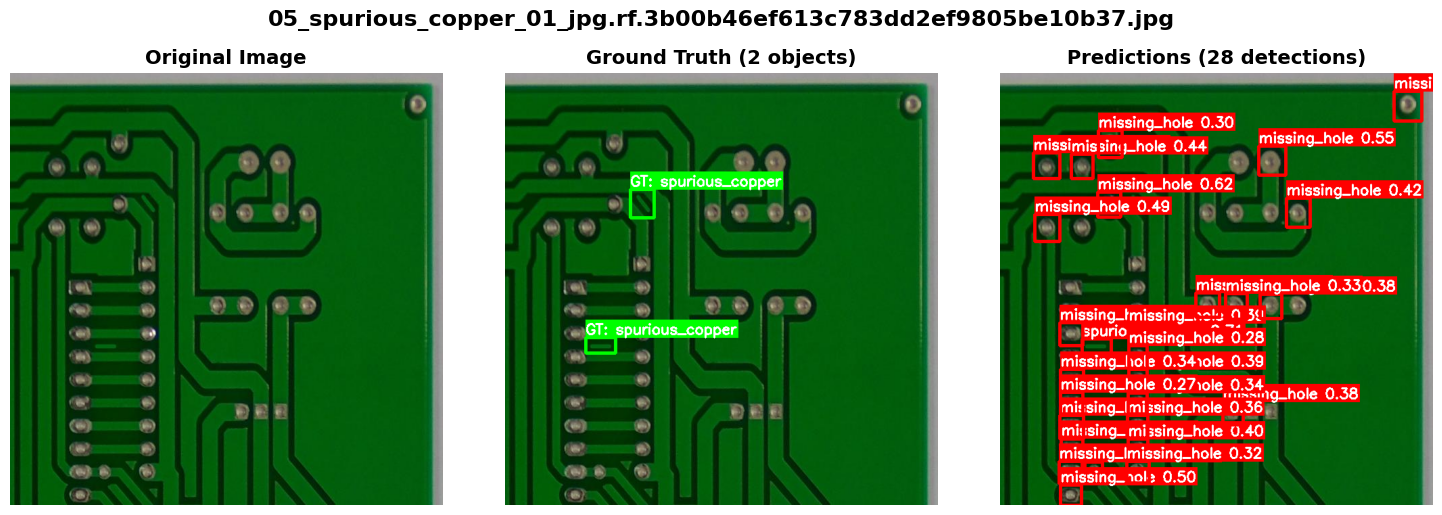

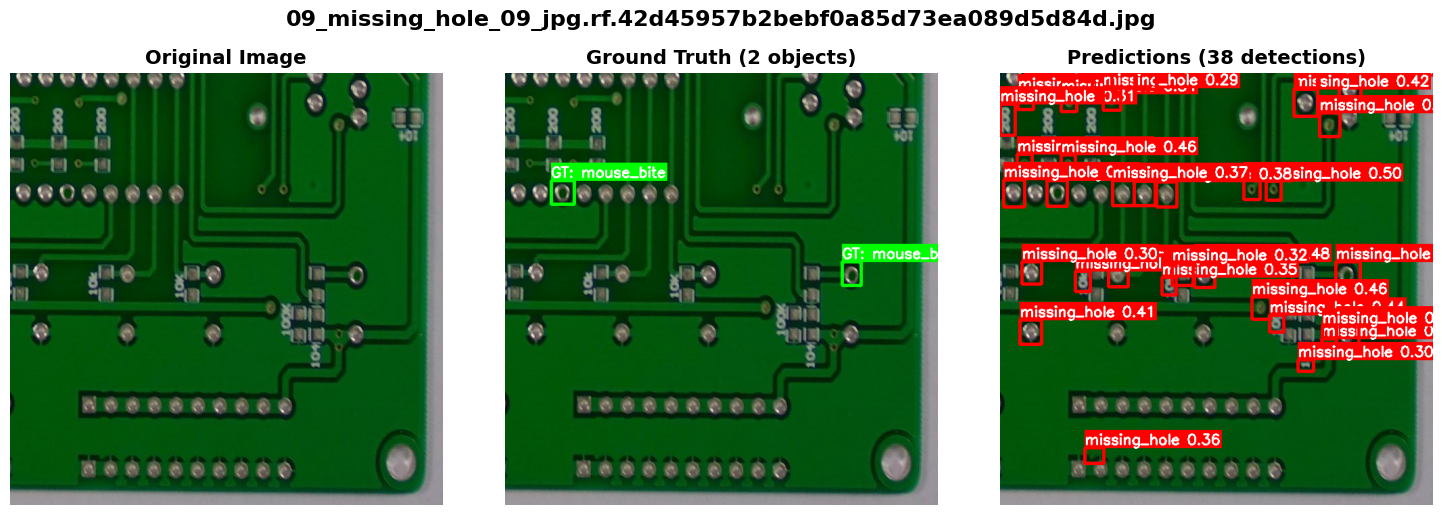

In [18]:
# 양자화 전 모델
visualize_predict(
    model_path=MODEL_PT,
    test_images_dir=f"{PROJECT_ROOT}/dataset/roboflow/test/images",
    label_dir=f"{PROJECT_ROOT}/dataset/roboflow/test/labels",
    num_samples=2,  # 5개 이미지 시각화
    conf=0.25
)

# MODEL_PT = WEIGHTS_DIR / "better.pt"
# MODEL_ENGINE = WEIGHTS_DIR / "better.engine"

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Found 186 images with defects
Loading /content/drive/MyDrive/likelion/PCB/weights/better.engine for TensorRT inference...


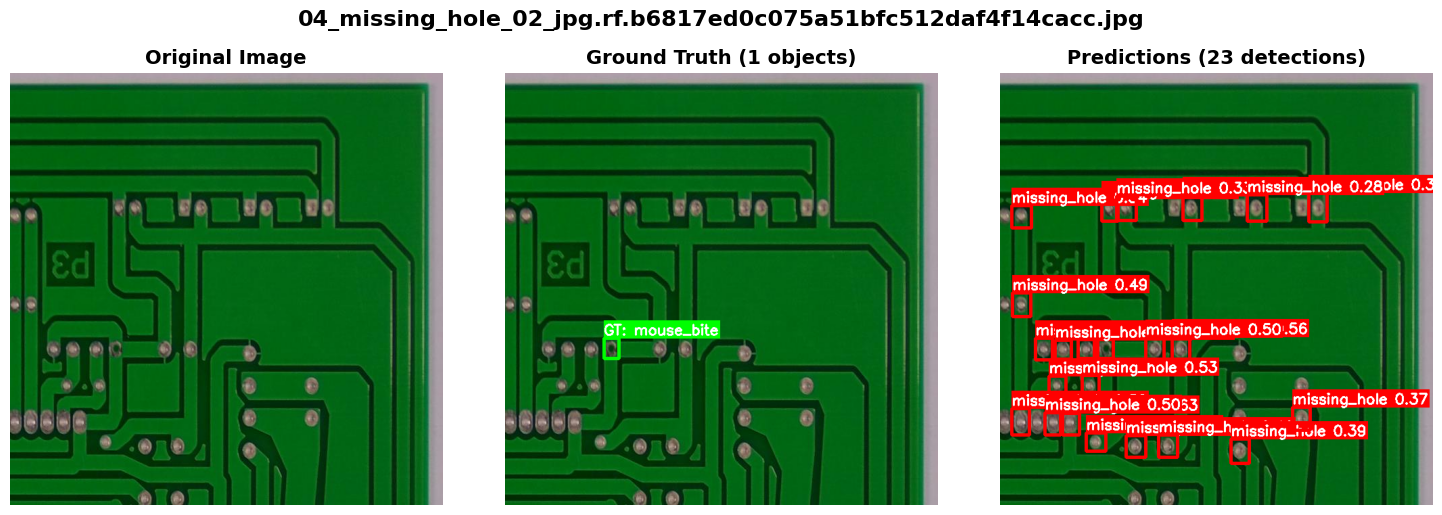

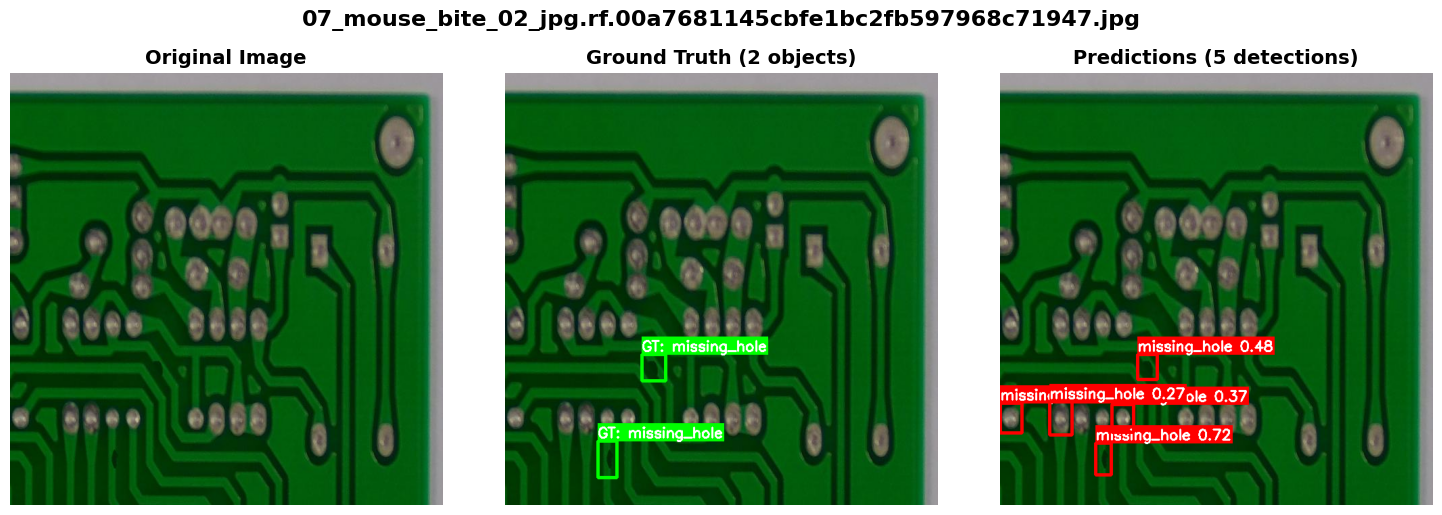

In [19]:
# 양자화 후 모델
visualize_predict(
    model_path=MODEL_ENGINE,
    test_images_dir=f"{PROJECT_ROOT}/dataset/roboflow/test/images",
    label_dir=f"{PROJECT_ROOT}/dataset/roboflow/test/labels",
    num_samples=2,  # 5개 이미지 시각화
    conf=0.25
)

# MODEL_PT = WEIGHTS_DIR / "better.pt"
# MODEL_ENGINE = WEIGHTS_DIR / "better.engine"